In [1]:
import warnings
warnings.filterwarnings('ignore')

import tqdm, json, random, sqlite3, pandas as pd

In [2]:
def get_database_schema(data_split, database_name):
    with sqlite3.connect(f'file:./dataset/{data_split}_set/{data_split}_databases/{database_name}/{database_name}.sqlite?mode=ro', uri=True) as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        schemas = {}
        for table in tables:
            cursor.execute("SELECT sql FROM sqlite_master WHERE type='table' AND name='{}';".format(table[0]))
            schemas[table[0]] = cursor.fetchone()[0]
        return schemas

def get_database_schema_as_context(data_split, database_name):
    database_schema = get_database_schema(data_split=data_split, database_name=database_name)
    context = "Based on the SQL db schema given below, you have to answer the question that follows it. Your answer should be a valid, correct SQL query. You are provided with a HINT to generate the SQL query.\n\n"
    context += f"SCHEMA: Tables in the database {database_name}: {', '.join(list(database_schema.keys()))}\n-------------------------\n"
    for key in database_schema.keys():
        context += f"CREATE query for table: {key}\n\n{' '.join(database_schema[key].split())}\n-------------------------\n"
    return context


def generate_data(data_split):
    data_path = f"./dataset/{data_split}_set/{data_split}.json"

    with open(data_path, 'r') as f:
        data_list = json.load(f)

    if data_split == 'train':
        random.seed(45)
        data_list = random.sample(data_list, k=len(data_list))
    
    examples = list()
    for data_point in tqdm.tqdm(data_list, desc=f"Processing {data_split.title()} Set"):
        context = get_database_schema_as_context(data_split=data_split, database_name=data_point['db_id'])
        context += f"QUESTION: {data_point['question']}\n\n"
        context += f"HINT: {data_point['evidence']}\n\n"
        examples.append({'database': data_point['db_id'], 'conversations': [{'from': 'human', 'value': context}, {'from': 'gpt', 'value': data_point['SQL']}]})

    df = pd.DataFrame(examples)
    return df

In [3]:
train_set = generate_data('train')
train_set['conversations'][0]

Processing Train Set: 100%|██████████| 9428/9428 [00:02<00:00, 3802.54it/s]


[{'from': 'human',
  'value': 'Based on the SQL db schema given below, you have to answer the question that follows it. Your answer should be a valid, correct SQL query. You are provided with a HINT to generate the SQL query.\n\nSCHEMA: Tables in the database student_loan: bool, person, disabled, enlist, filed_for_bankrupcy, longest_absense_from_school, male, no_payment_due, unemployed, enrolled\n-------------------------\nCREATE query for table: bool\n\nCREATE TABLE bool ( "name" TEXT default \'\' not null primary key )\n-------------------------\nCREATE query for table: person\n\nCREATE TABLE person ( "name" TEXT default \'\' not null primary key )\n-------------------------\nCREATE query for table: disabled\n\nCREATE TABLE disabled ( "name" TEXT default \'\' not null primary key, foreign key ("name") references person ("name") on update cascade on delete cascade )\n-------------------------\nCREATE query for table: enlist\n\nCREATE TABLE enlist ( "name" TEXT not null, organ TEXT not

In [4]:
dev_set = generate_data('dev')
dev_set['conversations'][0]

Processing Dev Set: 100%|██████████| 1534/1534 [00:00<00:00, 5809.15it/s]


[{'from': 'human',
  'value': 'Based on the SQL db schema given below, you have to answer the question that follows it. Your answer should be a valid, correct SQL query. You are provided with a HINT to generate the SQL query.\n\nSCHEMA: Tables in the database california_schools: frpm, satscores, schools\n-------------------------\nCREATE query for table: frpm\n\nCREATE TABLE frpm ( CDSCode TEXT not null primary key, `Academic Year` TEXT null, `County Code` TEXT null, `District Code` INTEGER null, `School Code` TEXT null, `County Name` TEXT null, `District Name` TEXT null, `School Name` TEXT null, `District Type` TEXT null, `School Type` TEXT null, `Educational Option Type` TEXT null, `NSLP Provision Status` TEXT null, `Charter School (Y/N)` INTEGER null, `Charter School Number` TEXT null, `Charter Funding Type` TEXT null, IRC INTEGER null, `Low Grade` TEXT null, `High Grade` TEXT null, `Enrollment (K-12)` REAL null, `Free Meal Count (K-12)` REAL null, `Percent (%) Eligible Free (K-12)`

In [5]:
train_set['database'].value_counts()

works_cycles              474
public_review_platform    381
retail_world              373
movie_3                   325
mondial_geo               293
                         ... 
trains                     40
shooting                   28
genes                      23
citeseer                   19
craftbeer                   6
Name: database, Length: 69, dtype: int64

In [6]:
dev_set['database'].value_counts()

card_games                 191
codebase_community         186
formula_1                  174
thrombosis_prediction      163
student_club               158
toxicology                 145
superhero                  129
european_football_2        129
financial                  106
california_schools          89
debit_card_specializing     64
Name: database, dtype: int64

<Axes: ylabel='Frequency'>

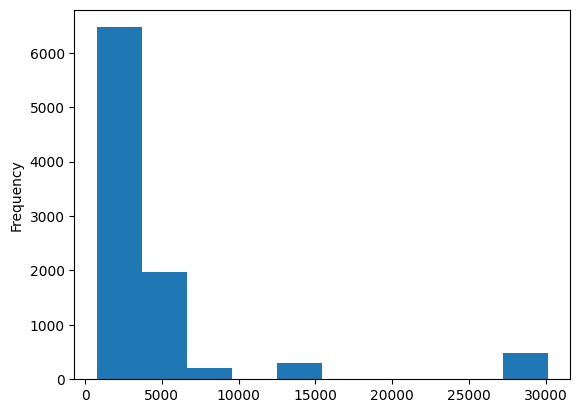

In [9]:
train_set['conversations'].apply(lambda x: len(x[0]['value'])).plot(kind='hist')

<Axes: ylabel='Frequency'>

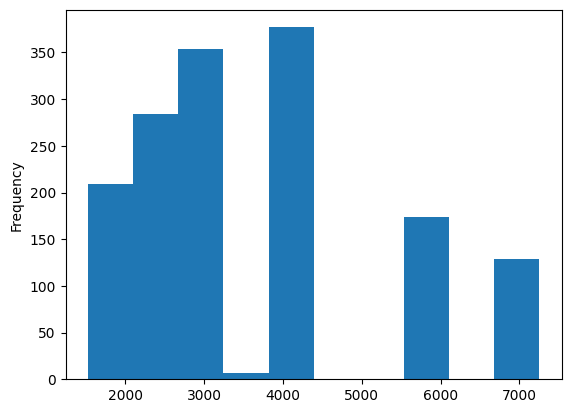

In [10]:
dev_set['conversations'].apply(lambda x: len(x[0]['value'])).plot(kind='hist')

In [7]:
train_set.to_csv('./train_set.csv', index=False)
dev_set.to_csv('./dev_set.csv', index=False)